In [1]:
!pip install holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.6 MB/s eta 0:00:00a 0:00:01


In [2]:
spark

# Set Up

In [3]:
import pandas as pd
from google.cloud import storage
from io import BytesIO
from datetime import datetime, date
import matplotlib.pyplot as plt
import holidays

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split, dayofweek
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline




In [4]:
bucket_name = 'my-bigdataproject-jg'
gs_path  = f'gs://{bucket_name}/'
cleaned_folder = 'cleaned/'
destination_folder = 'code_and_models/'

storage_client = storage.Client() 
bucket = storage_client.get_bucket(bucket_name)

# Weather DF

In [5]:
weather_files = gs_path + cleaned_folder + 'weather_data_*.parquet'
weather_df = spark.read.parquet(weather_files)

"""
Drop columns:
tempmax
tempmin
feelslikemax
feelslikemin
preciptype
cloudcover

visibility
humidity

Keep columns:
datetime
borough

temp
feelslike
precip
snow
snowdepth
windspeed
uvindex
conditions
"""

weather_df = weather_df.drop('tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'preciptype', 'cloudcover', 'visibility', 'humidity')

weather_df = weather_df.withColumnRenamed('borough', 'weather_borough')
weather_df = weather_df.withColumnRenamed('snow', 'snow_precip')

weather_df.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow_precip: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- uvindex: long (nullable = true)
 |-- conditions: string (nullable = true)
 |-- weather_borough: string (nullable = true)



# Taxi Trips DF

In [6]:
taxi_files = gs_path + cleaned_folder + "taxi_data/*.parquet"
taxi_df = spark.read.parquet(taxi_files)
taxi_df.printSchema()

root
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tip_percentage: double (nullable = true)



In [7]:
# Show the number of records for each unique RatecodeID
taxi_df.groupBy('RatecodeID').count().show()

# Show the number of records for each unique passenger_count
taxi_df.groupBy('passenger_count').count().show()


+----------+--------+
|RatecodeID|   count|
+----------+--------+
|         1|97966298|
|         6|     105|
|        99| 4059864|
|         2| 3520045|
+----------+--------+



+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|              1|75459398|
|              6| 1213461|
|              3| 3965406|
|              4| 1869862|
|              5| 1861532|
|              2|15463935|
|              0| 5712712|
|              7|       6|
+---------------+--------+



In [8]:
# create a new column pickup_date, which the date using the pickup_datetime column
taxi_df = taxi_df.withColumn('pickup_date', to_date(col('pickup_datetime')))

# create a new column pickup_hour, which the hour using the pickup_datetime column
taxi_df = taxi_df.withColumn('time_of_day', 
                             when((F.hour(F.col('pickup_datetime')) >= 5) & (F.hour(F.col('pickup_datetime')) < 12), 'morning')\
                             .when((F.hour(F.col('pickup_datetime')) >= 12) & (F.hour(F.col('pickup_datetime')) < 21), 'afternoon')\
                             .otherwise('night'))



# Remove the records with RatecodeID = 99 
taxi_df = taxi_df.filter(col('RatecodeID') != 99)

# Remove the records passenger_count = 0
taxi_df = taxi_df.filter(col('passenger_count') != 0)

# Remove the records with fare_amount < 3.70 (minimum fare amount)
taxi_df = taxi_df.filter(col('fare_amount') >= 3.70)

# Remove the records with total_amount <= 4.20 (minimum total amount)
taxi_df = taxi_df.filter(col('total_amount') > 4.20)

# Remove the records with trip_distance < 1/5 mile
taxi_df = taxi_df.filter(col('trip_distance') >= 0.2)


taxi_df = taxi_df.drop('dropoff_datetime', 'RatecodeID', 'payment_type', 'total_amount', 'pickup_datetime', 'tip_amount')


# Taxi Zone DF

In [9]:
taxi_zone_file = gs_path + cleaned_folder + 'taxi_zones_data.parquet'
taxi_zone_df = spark.read.parquet(taxi_zone_file)
taxi_zone_df = taxi_zone_df.drop('zone')
taxi_zone_df.printSchema()


root
 |-- LocationID: long (nullable = true)
 |-- borough: string (nullable = true)



In [10]:
# Show the unique boroughs in the taxi_zone_df DataFrame
taxi_zone_df.select('borough').distinct().show()

+-------------+
|      borough|
+-------------+
|          EWR|
|     Brooklyn|
|    Manhattan|
|        Bronx|
|       Queens|
|Staten Island|
+-------------+



## Taxi data frames combined

In [11]:
# PU Location join
taxi_df = taxi_df.join(taxi_zone_df, taxi_df.PULocationID == taxi_zone_df.LocationID, how='left')


taxi_df = taxi_df.withColumnRenamed('Borough', 'PUBorough')
taxi_df = taxi_df.drop('LocationID')

# DO Location join
taxi_df = taxi_df.join(taxi_zone_df, taxi_df.DOLocationID == taxi_zone_df.LocationID, how='left')

taxi_df = taxi_df.withColumnRenamed('Borough', 'DOBorough')
taxi_df = taxi_df.drop('LocationID')

# Drop the PULocationID and DOLocationID columns
taxi_df = taxi_df.drop('PULocationID', 'DOLocationID')

# Drop the records where the PUBorough or DOBorough is 'EWR'
taxi_df = taxi_df.filter((taxi_df.PUBorough != 'EWR'))
taxi_df = taxi_df.filter((taxi_df.DOBorough != 'EWR'))

taxi_df.show(15)

+---------------+-------------+-----------+------------------+-----------+-----------+---------+---------+
|passenger_count|trip_distance|fare_amount|    tip_percentage|pickup_date|time_of_day|PUBorough|DOBorough|
+---------------+-------------+-----------+------------------+-----------+-----------+---------+---------+
|              1|          1.7|        9.5|16.614420062695924| 2022-10-01|      night|Manhattan|Manhattan|
|              2|         0.72|        5.5|               0.0| 2022-10-01|      night|Manhattan|Manhattan|
|              1|         1.74|        9.0|16.666666666666668| 2022-10-01|      night|Manhattan|Manhattan|
|              1|          6.8|       25.5|               0.0| 2022-10-01|      night|Manhattan|Manhattan|
|              3|         1.88|       10.5|               0.0| 2022-10-01|      night|Manhattan|   Queens|
|              1|         12.2|       41.0|6.2761506276150625| 2022-10-01|      night|Manhattan| Brooklyn|
|              1|         7.79|      

# Combined Data Frame

In [12]:
combined_df = taxi_df.join(weather_df, [taxi_df.pickup_date == weather_df.datetime, taxi_df.PUBorough == weather_df.weather_borough])

combined_df = combined_df.drop('datetime')
combined_df = combined_df.drop('weather_borough')

combined_df.printSchema()


root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_percentage: double (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- time_of_day: string (nullable = false)
 |-- PUBorough: string (nullable = true)
 |-- DOBorough: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- snow_precip: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- uvindex: long (nullable = true)
 |-- conditions: string (nullable = true)



In [13]:
# Summarize the columns: tip_percentage, trip_distance, fare_amount, passenger_count
combined_df.select('tip_percentage', 'trip_distance', 'fare_amount', 'passenger_count').summary().show()

24/12/02 00:21:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------------+------------------+------------------+
|summary|    tip_percentage|    trip_distance|       fare_amount|   passenger_count|
+-------+------------------+-----------------+------------------+------------------+
|  count|          97398131|         97398131|          97398131|          97398131|
|   mean| 12.13945806002032|3.306861736289247|15.444750668365357| 1.428032659066117|
| stddev| 7.689197821997535|4.100784058800206|13.195544503203674|0.9526616552088206|
|    min|               0.0|              0.2|               3.7|                 1|
|    25%| 5.952380952380952|             1.11|               7.5|                 1|
|    50%|16.614420062695924|             1.83|              11.0|                 1|
|    75%|16.666666666666664|             3.33|              17.0|                 1|
|    max| 95.62278725458643|             59.9|             249.4|                 7|
+-------+------------------+-----------------+------------------+

# Datetime features

In [14]:
# datetime

# month
combined_df = combined_df.withColumn('month', month(col('pickup_date')))
# dayofweek
combined_df = combined_df.withColumn('dayofweek', dayofweek(col('pickup_date')))

# weekend
combined_df = combined_df.withColumn('weekend', when(col('dayofweek') == 1, 1.0).when(col('dayofweek') == 7, 1.0).otherwise(0))

# holiday
combined_df = combined_df.withColumn('pickup_date', to_date(col('pickup_date')))

# Get the min and max date in the datetime column
min_date = combined_df.agg({"pickup_date": "min"}).collect()[0][0]
max_date = combined_df.agg({"pickup_date": "max"}).collect()[0][0]


# Get the holidays observed in New York
us_holidays = holidays.UnitedStates(years=[min_date.year, max_date.year], observed=True, subdiv='NY')

#print(us_holidays)

# Keep only the dates of the holidays
us_holidays = list(us_holidays.keys())

# Create a new column holiday and set it to 1 if the date is a holiday, 0 otherwise
combined_df = combined_df.withColumn('holiday', when(col('pickup_date').isin(us_holidays), 1).otherwise(0))

# UDF Condition Features

In [15]:
# conditions

# Select all the distinct options for conditions and save them in a list
conditions = combined_df.select('conditions').distinct().rdd.flatMap(lambda x: x).collect()
# Split the string into a list
conditions = [x.split(', ') for x in conditions]

# Flatten the list
conditions = [item for sublist in conditions for item in sublist]
# Keep the unique values only
conditions = list(set(conditions))

print(conditions)

# Create a new column for each condition
for condition in conditions:
    combined_df = combined_df.withColumn(condition, when(col('conditions').contains(condition), 1).otherwise(0))


['Overcast', 'Partially cloudy', 'Rain', 'Clear', 'Ice', 'Snow', 'Freezing Drizzle/Freezing Rain']


# Tip Label

In [16]:
# Use Tip Percentage to create a new column tip_class
# If the tip percentage is greater than 10%, the tip_class is 1, otherwise 0
combined_df = combined_df.withColumn('tip_class', when(col('tip_percentage') > 10, 1).otherwise(0))


# Pipeline

## String Indexer

In [17]:
# String Index columns
indexer_input = ['PUBorough', 'DOBorough', 'time_of_day']
indexer_output = [x + '_index' for x in indexer_input]
indexer = StringIndexer(inputCols=indexer_input, outputCols=indexer_output)


## One Hot Encoder

In [18]:
encoder_output = [x + '_encoded' for x in indexer_input]
encoder = OneHotEncoder(inputCols=indexer_output, outputCols=encoder_output)

## Vector Assembler

In [19]:
"""
temp
feelslike
precip
snow
snowdepth
windspeed
uvindex
conditions
 'month', 'dayofweek', 'weekend', 'holiday', 'trip_distance', 'passenger_count', 'fare_amount'
"""

encode_directly = [
    'temp',
    'feelslike',
    'precip',
    'snow_precip',
    'snowdepth',
    'windspeed',
    'uvindex',
    'month',
    'dayofweek',
    'weekend',
    'holiday',
    'trip_distance',
    'passenger_count',
    'fare_amount'
]


input_cols =  conditions + encoder_output + encode_directly
print(input_cols)

['Overcast', 'Partially cloudy', 'Rain', 'Clear', 'Ice', 'Snow', 'Freezing Drizzle/Freezing Rain', 'PUBorough_encoded', 'DOBorough_encoded', 'time_of_day_encoded', 'temp', 'feelslike', 'precip', 'snow_precip', 'snowdepth', 'windspeed', 'uvindex', 'month', 'dayofweek', 'weekend', 'holiday', 'trip_distance', 'passenger_count', 'fare_amount']


In [20]:
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Save the pipeline with features

In [ ]:
print('Saving the transformed data...')
# Create a new frame with the transformed data
pipeline = Pipeline(stages=[indexer, encoder, assembler])
model = pipeline.fit(combined_df)
transformed_df = model.transform(combined_df)

# Save the transformed data
transformed_df.write.parquet(gs_path + destination_folder + 'features', mode='overwrite')
print('Transformed data saved!')

Saving the transformed data...


# Train / Test

In [21]:
train_df, test_df = combined_df.randomSplit([0.7, 0.3], seed=42)

# Pipeline  

In [22]:
lr = LogisticRegression(featuresCol='features', labelCol='tip_class', maxIter=10, regParam=0.1, elasticNetParam=0.8)

In [23]:
lr_pipeline = Pipeline(stages=[
    indexer,
    encoder,
    assembler,
    lr
])

# Cross validating

In [24]:
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])
grid = grid.build()

print('Number of models to be tested: ', len(grid))

# Binary classification evaluator with area under ROC as the metric
evaluator = BinaryClassificationEvaluator(labelCol='tip_class', metricName='areaUnderROC')


cv = CrossValidator(
    estimator=lr_pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

all_models = cv.fit(train_df)



Number of models to be tested:  18


In [27]:
# predictions
predictions = all_models.transform(test_df)

# Calculate the AUC
#auc = evaluator.evaluate(predictions)

#print(f"AUC: {auc}")

# Create a confusion matrix
predictions.groupby('tip_class', 'prediction').count().show()
cm = predictions.groupby('tip_class').pivot('prediction').count().fillna(0).collect()

def calculate_metrics(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = calculate_metrics(cm)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

+---------+----------+--------+
|tip_class|prediction|   count|
+---------+----------+--------+
|        1|       1.0|19477996|
|        0|       0.0|  222421|
|        0|       1.0| 9403331|
|        1|       0.0|  116542|
+---------+----------+--------+



Accuracy: 0.3257966638934795
Precision: 0.32558514364661983
Recall: 0.9768931300120759
F1 Score: 0.4883949260342494


Best Model Stages: 
[StringIndexerModel: uid=StringIndexer_e170dbb8c459, handleInvalid=error, numInputCols=3, numOutputCols=3, OneHotEncoderModel: uid=OneHotEncoder_4920a6bb06a4, dropLast=true, handleInvalid=error, numInputCols=3, numOutputCols=3, VectorAssembler_cd6d81c0161a, LogisticRegressionModel: uid=LogisticRegression_1af197379a4a, numClasses=2, numFeatures=31]


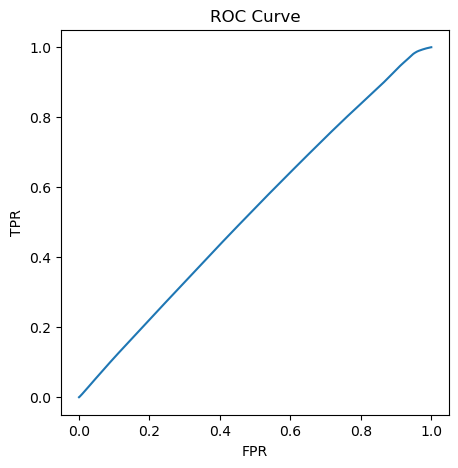

In [29]:
# Best model 
best_model = all_models.bestModel

print(f"Best Model Stages: \n{best_model.stages}")

# Parameters of the best model
best_model.stages[-1].extractParamMap()

# Create a ROC curve
trainingSummary = best_model.stages[-1].summary

plt.figure(figsize=(5, 5))
plt.plot(trainingSummary.roc.select('FPR').collect(),
         trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()


In [30]:
coefficients = best_model.stages[-1].coefficients
print("bestModel coefficients", coefficients)

bestModel coefficients [-0.007670597462718025,-0.024683855608766035,0.009316579071450429,-0.0008553878210689173,-0.03668650672114028,-0.02673239799883309,0.0725746316618052,0.16270057122708267,-0.12561592789797987,-0.1647391813289801,-1.463877988802972,0.2725812856032966,-0.24597895589054705,0.11467895833079077,-1.256312534564981,-0.09300010201614012,-0.12377713020264386,-0.0013795133203401754,2.4538869999996782e-05,-0.002047822578188081,0.022043636542269623,-0.02363681249080406,6.559685562728564e-05,-0.0007459205387601299,0.004937840469712163,-0.00040805106663578433,-0.03809368941642738,-0.06726673870250348,0.031632082239539595,-0.0386611782933988,-0.004139321476713787]


# Save the Model

In [ ]:
# Save the model
print('Saving the model')
model_path = gs_path + destination_folder + 'model'
best_model.write().overwrite().save(model_path)
print('Model saved')